<a href="https://colab.research.google.com/github/Jakondo/Python-for-DL-and-CV/blob/master/Ch9_CIFAR_Classification_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Chapter 9: CIFAR 10 Classification - PyTorch

---



In [0]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

In [0]:
device = torch.device("cuda: 0" if torch.cuda.is_available() else "cpu")

In [7]:
transform_train = transforms.Compose([transforms.Resize((32, 32)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,), (0.5,))
                                      ])

transform = transforms.Compose([transforms.Resize((32, 32)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))
                               ])
training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

170500096it [00:02, 66343614.76it/s]                               


Files already downloaded and verified


In [0]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

In [0]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

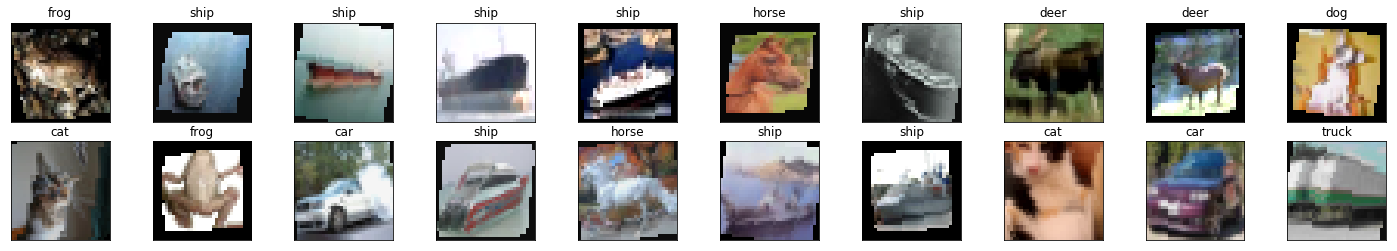

In [10]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [0]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1)
    self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
    self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
    self.fc1 = nn.Linear(4*4*64, 500)
    self.fc2 = nn.Linear(500, 10)
    self.dropout1 = nn.Dropout(0.5) 
    
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)    
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x, 2, 2)
    x = x.view(-1, 4*4*64)
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    x = self.fc2(x)
    return x

In [12]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout1): Dropout(p=0.5)
)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [14]:
epochs = 15
loss_hist = []
correct_hist = []
val_loss_hist = []
val_cor_hist = []

for e in range(epochs):
  run_loss = 0.0
  run_correct = 0.0
  val_run_loss = 0.0
  val_run_cor = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)    
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    run_correct += torch.sum(preds == labels.data)    
    run_loss += loss.item()
    
  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)    
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_run_cor += torch.sum(val_preds == val_labels.data)    
        val_run_loss += val_loss.item()
      
    epoch_loss = run_loss/len(training_loader)
    epoch_acc = run_correct.float()/len(training_loader)
    loss_hist.append(epoch_loss)
    correct_hist.append(epoch_acc)
    
    val_epoch_loss = val_run_loss/len(validation_loader)
    val_epoch_acc = val_run_cor.float()/len(validation_loader)
    val_loss_hist.append(val_epoch_loss)
    val_cor_hist.append(val_epoch_acc)
    
    print('epoch: ', (e+1))    
    print('training loss: {:.4f}, accuracy {:.4f}'.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, accuracy {:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))

epoch:  1
training loss: 1.6763, accuracy 38.7380
validation loss: 1.3608, accuracy 51.0300
epoch:  2
training loss: 1.3747, accuracy 50.4340
validation loss: 1.2469, accuracy 55.9900
epoch:  3
training loss: 1.2610, accuracy 55.0460
validation loss: 1.1133, accuracy 60.2000
epoch:  4
training loss: 1.1760, accuracy 58.1800
validation loss: 1.0575, accuracy 61.6800
epoch:  5
training loss: 1.1157, accuracy 60.6500
validation loss: 1.0007, accuracy 64.6000
epoch:  6
training loss: 1.0670, accuracy 62.1080
validation loss: 0.9750, accuracy 66.4200
epoch:  7
training loss: 1.0259, accuracy 63.8240
validation loss: 0.9698, accuracy 66.0500
epoch:  8
training loss: 0.9983, accuracy 64.9500
validation loss: 0.9184, accuracy 67.5400
epoch:  9
training loss: 0.9582, accuracy 66.4040
validation loss: 0.8869, accuracy 69.1600
epoch:  10
training loss: 0.9368, accuracy 67.1120
validation loss: 0.8949, accuracy 69.5200
epoch:  11
training loss: 0.9226, accuracy 67.6880
validation loss: 0.8456, acc

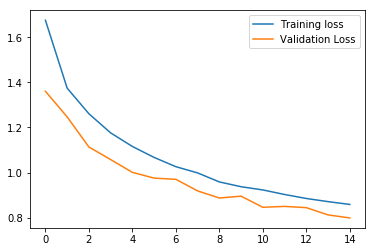

In [15]:
plt.plot(loss_hist, label='Training loss')
plt.plot(val_loss_hist, label='Validation Loss')
plt.legend();

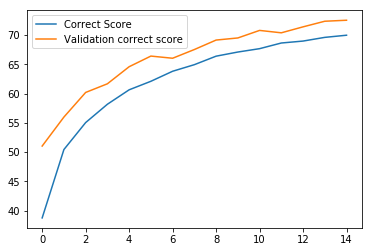

In [16]:
plt.plot(correct_hist, label='Correct Score')
plt.plot(val_cor_hist, label='Validation correct score')
plt.legend();

#Test

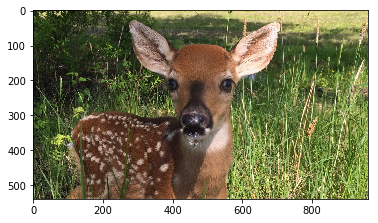

In [30]:
import requests
import PIL.ImageOps
from PIL import Image
url = 'https://img.yle.fi/uutiset/tampere/article10292800.ece/ALTERNATES/w960/laukonpeura%20Laukko%20peura%20valkoh%C3%A4nt%C3%A4kauris%20korjattu%20versio.jpg'
response = requests.get(url, stream=True)
img = Image.open(response.raw)
plt.imshow(img);

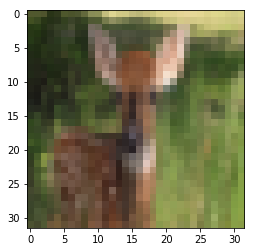

In [31]:
img = transform(img)
plt.imshow(im_convert(img));

In [32]:
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

deer


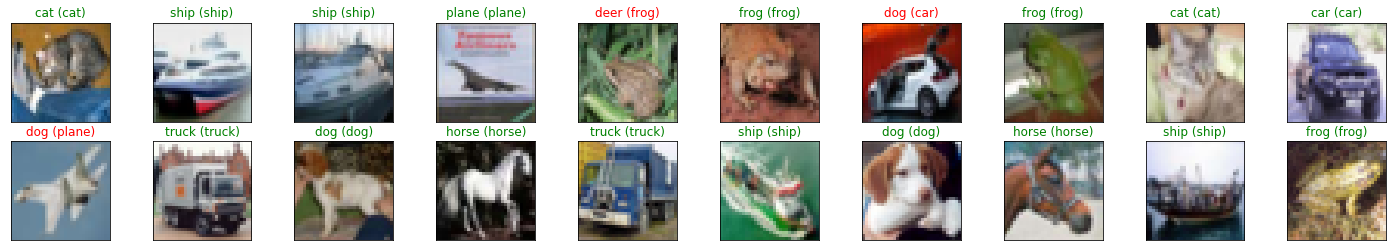

In [33]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)

output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))
  